In [ ]:
### AN ATTEMPT AT ANALYTICALLY SIMULATING THE SILICON DETECTOR RESPONSE ###
### (FAILED) ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy as sp
import math as m


3600000.0 1280000.0
2.7777777777777776e-09
3.906250000000001e-09
6 [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83

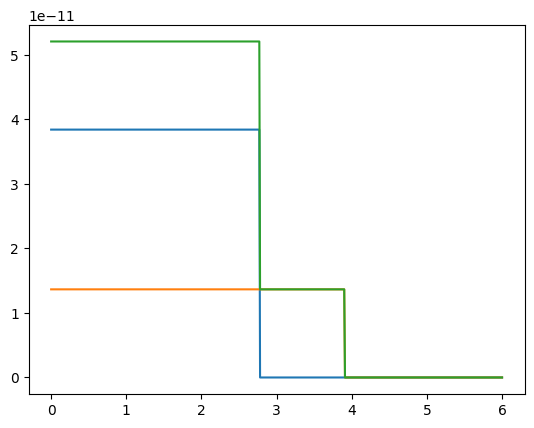

In [5]:
CHARGE = 1.6e-19
xv_um = 150         #um
xi_um = 50          #um

xi = xi_um * 1e-4   #cm
xg = 0              #cm          
xv = xv_um * 1e-4   #cm
bias = 40           #V
mu_e = 1350         #cm^2/Vs
mu_h = 480          #cm^2/Vs
x = np.linspace(xg, xv, 10*xv_um+1)


# gives electric field for every x position in an array. 
# E field values in units of V/cm
def ConstElectricField(x, bias=bias):
    E_ = bias / (xv - xg)
    E_field = np.full_like(x, E_)
    #print(E_)   
    return E_field, E_

def t_final(type, x):
    if type == 'electron':
        mu = mu_e
        x_start = xi
        x_end = xv
    if type == 'hole':
        mu = mu_h
        x_end = xi
        x_start = xg
    integrand = lambda x, mu: 1 / (mu * ConstElectricField(x)[0])
    t_f = sp.integrate.quad(integrand, x_start, x_end, args=(mu))
    print(t_f[0])
    return t_f[0]
    
#   Var types: t = array ; tf = float ; E_val = float ; weighting_field_val = float; type = string
def const_current(t, tf, E_val, weighting_field_val, type):
    if type == 'electron':
        mu = mu_e
    if type == 'hole':
        mu = mu_h
    v_const = mu * E_val
    velocity_vs_t = v_const * np.heaviside(tf-t, 1) * np.heaviside(t, 1) # step function carrier velocity to account for charge collection
    current = weighting_field_val * velocity_vs_t * CHARGE               # shockley ramo theorem 
    return current


weighting_field, W_const = ConstElectricField(x, bias=1)
E_real, E_const = ConstElectricField(x)
ve_temp = mu_e * E_const
vh_temp = mu_h * E_const
print(ve_temp, vh_temp)
t_fe = t_final('electron', x) * 1e9     #ns
t_fh = t_final('hole', x) * 1e9         #ns
te_range = m.ceil(1.5 * t_fe)
th_range = m.ceil(1.5 * t_fh)
t_range_max = max(te_range, th_range)

t = np.linspace(0, t_range_max, t_range_max * 100 + 1)
print(t_range_max, t)

current_e = const_current(t, t_fe, E_const, W_const, 'electron')
current_h = const_current(t, t_fh, E_const, W_const, 'hole')
sum_current = current_e + current_h

plt.plot(t, current_e)
plt.plot(t, current_h)
plt.plot(t, sum_current)




Text(0.5, 1.0, 'Charge vs Time')

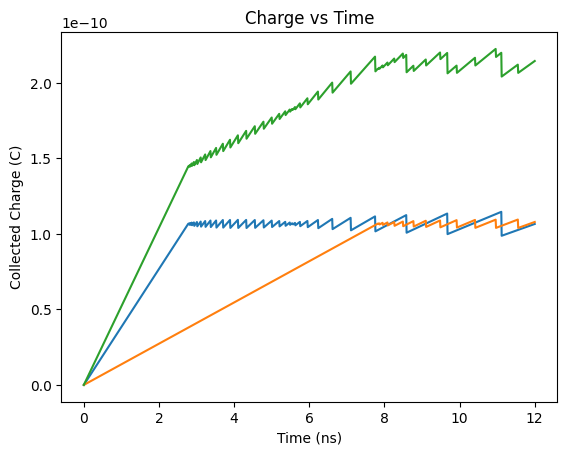

In [3]:

def int_current(t_array, current):
    indef_inte = []
    indef_inth = []
    indef_sum = []
    for t in t_array:
        integrale = sp.integrate.quad(const_current, 0, t, args=(t_fe, E_const, W_const, 'electron'))[0]
        integralh = sp.integrate.quad(const_current, 0, t, args=(t_fh, E_const, W_const, 'hole'))[0]
        indef_inte.append(integrale)
        indef_inth.append(integralh)
        indef_sum.append(integrale + integralh)
    return np.array(indef_inte), np.array(indef_inth), np.array(indef_sum)

integral_e, integral_h, integral_s = int_current(t, sum_current)
plt.plot(t, integral_e, label='electron current')
plt.plot(t, integral_h, label='hole current')
plt.plot(t, integral_s, label='sum current')
plt.xlabel('Time (ns)')
plt.ylabel('Collected Charge (C)')
plt.title('Charge vs Time')
